In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

# Data Prep


In [2]:
raw_data = pd.read_csv("all_data.csv")
raw_data

,CURRENT_FIX_IA_NUM__variance,CURRENT_FIX_IA_NUM__standard_deviation,CURRENT_FIX_Y__variance,CURRENT_FIX_Y__standard_deviation,CURRENT_FIX_Y__variation_coefficient,CURRENT_FIX_X__quantile__q_0.2,"CURRENT_FIX_Y__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.2","CURRENT_FIX_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2","CURRENT_FIX_Y__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.2",CURRENT_FIX_X__quantile__q_0.1,...,"CURRENT_FIX_X__fft_coefficient__attr_""angle""__coeff_4","CURRENT_FIX_IA_NUM__fft_coefficient__attr_""angle""__coeff_12","CURRENT_FIX_DURATION__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""var""",legitpresence,PUPIL_SIZE_MAX,PUPIL_SIZE_MEAN,PUPIL_SIZE_MIN,id,Email_ResponseRT,Accuracy
0,1584.431406,39.804917,19857.000913,140.914871,0.260624,487.02,341.760275,267.225475,10.505000,458.46,...,-121.161034,-161.709534,7326.268000,1,874.0,788.61,717.0,101_a2_1,9862,1
1,3194.096876,56.516342,46335.815953,215.257557,0.356329,487.50,11166.900277,7446.762438,61.057895,387.16,...,73.459236,-82.078259,-50.789796,1,916.0,797.07,695.0,101_a2_10,14084,1
2,147.448889,12.142853,1982.753956,44.528125,0.096715,356.66,34.001224,18.485306,4.457143,352.34,...,81.572262,43.596152,-5916.680000,0,843.0,766.47,728.0,101_a2_100,3870,1
3,2500.239662,50.002397,35441.592789,188.259376,0.366127,379.04,442.135238,313.786700,12.657447,344.62,...,-143.399516,-43.584553,656.565020,1,910.0,815.15,713.0,101_a2_13,19063,1
4,899.136742,29.985609,11720.139667,108.259594,0.206704,414.60,485.702222,328.378889,12.666667,378.66,...,128.588371,66.635346,4410.849383,0,946.0,844.33,778.0,101_a2_15,6305,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15533,788.943311,28.088135,9370.990612,96.803877,0.194905,491.50,2514.597284,1494.680247,42.355556,425.30,...,-82.353079,43.596152,-2795.300000,1,749.0,716.30,687.0,246_g1_92,5397,1
15534,753.802630,27.455466,9845.464365,99.224313,0.197362,366.06,326.678574,196.636942,11.418182,336.94,...,151.398050,104.200622,1996.583333,0,759.0,709.42,667.0,246_g1_94,20555,1
15535,2329.848889,48.268508,31907.433600,178.626520,0.368241,377.88,1721.562222,1364.335556,24.233333,343.00,...,22.413354,43.596152,-1960.000000,0,756.0,712.60,678.0,246_g1_96,3796,1
15536,910.083333,30.167587,11185.861265,105.763232,0.177473,414.00,703.172853,502.457064,17.836842,401.50,...,34.242973,130.158330,-1277.736000,1,743.0,695.59,657.0,246_g1_97,8861,1


In [4]:
columns_to_drop = [
    "id",  # id combines RECORDING_SESSION_LABEL and TRIAL_INDEX to identify a unique trial
    "RECORDING_SESSION_LABEL",  # subject identifier
    "TRIAL_INDEX",
    "trial",
    "CURRENT_FIX_INTEREST_AREA_LABEL",
]

# Drop columns in columns_to_drop from data
data = (
    raw_data[[c for c in raw_data.columns if c not in columns_to_drop]].dropna().copy()
)

partition_cols = ["legitpresence"]

sample_sizes = data.groupby(partition_cols).size()
print("sample balance", sample_sizes)

sample_sizes = data.groupby(partition_cols).size()
assert sample_sizes.min() == sample_sizes.max()

data.drop(columns="Accuracy", inplace=True)


# Make sure the data has been properly cleaned
for c in data.columns:
    assert (
        "." not in data[c].values
    ), f"Column {c} contains '.' in values, which is not allowed."

data

sample balance legitpresence
0    7769
1    7769
dtype: int64


,CURRENT_FIX_IA_NUM__variance,CURRENT_FIX_IA_NUM__standard_deviation,CURRENT_FIX_Y__variance,CURRENT_FIX_Y__standard_deviation,CURRENT_FIX_Y__variation_coefficient,CURRENT_FIX_X__quantile__q_0.2,"CURRENT_FIX_Y__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.2","CURRENT_FIX_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2","CURRENT_FIX_Y__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.2",CURRENT_FIX_X__quantile__q_0.1,...,CURRENT_FIX_IA_NUM__fourier_entropy__bins_10,"CURRENT_FIX_END__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)","CURRENT_FIX_X__fft_coefficient__attr_""angle""__coeff_4","CURRENT_FIX_IA_NUM__fft_coefficient__attr_""angle""__coeff_12","CURRENT_FIX_DURATION__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""var""",legitpresence,PUPIL_SIZE_MAX,PUPIL_SIZE_MEAN,PUPIL_SIZE_MIN,Email_ResponseRT
0,1584.431406,39.804917,19857.000913,140.914871,0.260624,487.02,341.760275,267.225475,10.505000,458.46,...,0.367649,-352.232402,-121.161034,-161.709534,7326.268000,1,874.0,788.61,717.0,9862
1,3194.096876,56.516342,46335.815953,215.257557,0.356329,487.50,11166.900277,7446.762438,61.057895,387.16,...,1.192335,-2918.065276,73.459236,-82.078259,-50.789796,1,916.0,797.07,695.0,14084
2,147.448889,12.142853,1982.753956,44.528125,0.096715,356.66,34.001224,18.485306,4.457143,352.34,...,1.073543,4713.921267,81.572262,43.596152,-5916.680000,0,843.0,766.47,728.0,3870
3,2500.239662,50.002397,35441.592789,188.259376,0.366127,379.04,442.135238,313.786700,12.657447,344.62,...,0.216414,-5330.057875,-143.399516,-43.584553,656.565020,1,910.0,815.15,713.0,19063
4,899.136742,29.985609,11720.139667,108.259594,0.206704,414.60,485.702222,328.378889,12.666667,378.66,...,0.485094,3214.581830,128.588371,66.635346,4410.849383,0,946.0,844.33,778.0,6305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15533,788.943311,28.088135,9370.990612,96.803877,0.194905,491.50,2514.597284,1494.680247,42.355556,425.30,...,1.515708,2819.654519,-82.353079,43.596152,-2795.300000,1,749.0,716.30,687.0,5397
15534,753.802630,27.455466,9845.464365,99.224313,0.197362,366.06,326.678574,196.636942,11.418182,336.94,...,0.438435,-5141.303345,151.398050,104.200622,1996.583333,0,759.0,709.42,667.0,20555
15535,2329.848889,48.268508,31907.433600,178.626520,0.368241,377.88,1721.562222,1364.335556,24.233333,343.00,...,1.494175,4813.167530,22.413354,43.596152,-1960.000000,0,756.0,712.60,678.0,3796
15536,910.083333,30.167587,11185.861265,105.763232,0.177473,414.00,703.172853,502.457064,17.836842,401.50,...,0.536665,1227.086152,34.242973,130.158330,-1277.736000,1,743.0,695.59,657.0,8861


In [5]:
X_df = data.drop(columns="legitpresence")  # Remove target column from training data
X = X_df.values
y = data["legitpresence"]  # designate target column for correct prediction
y = 1 - y  # Invert legitpresence so that 1 = phishing, 0 = legit

In [7]:
# Split the data into training (80%), cross-validation (10%), and test (10%)

# 80% training, 20% for test
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state=1993
)

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Print dataset sizes for verification
print(f"Training dataset size: {len(X_train)}")
print(f"Test dataset size: {len(X_test)}")

Training dataset size: 12430
Test dataset size: 3108


In [8]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    matthews_corrcoef,
)
import xgboost as xgb
from time import perf_counter

# All Models


In [9]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")


latest_results = None


def param_search(model, params):
    model_name = type(model).__name__

    # Make sure not to double parallelize
    if hasattr(model, "n_jobs"):
        model.n_jobs = 1

    # Some models don't have feature importances, so allow skipping feature selection
    skip_feature_selection = params.pop("_skip_feature_selection", False)
    if skip_feature_selection:
        pipe = model
    else:
        for p in list(params.keys()):
            v = params.pop(p)
            # Rename the parameters so that it works in the pipeline
            params[f"estimator__{p}"] = v

        pipe = RFECV(model, step=0.1, cv=5, n_jobs=1)

    search_params = dict(
        cv=10,
        scoring="accuracy",
        # n_jobs=8,
        n_jobs=-1,
    )
    if sum(len(v) for v in params.values()) <= 20:
        search = GridSearchCV(
            pipe,
            params,
            **search_params,
        )
    else:
        search = RandomizedSearchCV(
            pipe,
            params,
            n_iter=20,
            random_state=1993,
            **search_params,
        )

    search.fit(X_train, y_train)

    results = {}
    for params in search.cv_results_["params"]:
        for p, v in params.items():
            results.setdefault(p.removeprefix("estimator__"), []).append(v)

    global latest_results
    latest_results = results

    df = (
        pd.DataFrame(
            {
                "model": model_name,
                "mean_test_score": search.cv_results_["mean_test_score"],
                "std_test_score": search.cv_results_["std_test_score"],
                **results,
            }
        )
        .sort_values("mean_test_score", ascending=False)
        .reset_index(drop=True)
    )
    latest_results = df
    if skip_feature_selection:
        df["n_features"] = X_train.shape[1]
        df["ranking"] = ""
        df["features"] = f"{list(X_df.columns)}"
        return df

    try:
        df["n_features"] = search.best_estimator_.n_features_
        rankings = {
            k: search.best_estimator_.ranking_[i] for i, k in enumerate(X_df.columns)
        }
        df["ranking"] = f"{rankings}"
        features = np.array(X_df.columns)[search.best_estimator_.support_].tolist()
        df["features"] = f"{features}"
    except Exception as e:
        print(f"Error retrieving feature rankings for {model_name}: {e}")
        print(
            f"Selected features: {search.best_estimator_.n_features_} out of {X_train.shape[1]}"
        )
        print(f"Selected features: {search.best_estimator_.support_}")

    return df


model_params = [
    (
        RandomForestClassifier(),
        {
            "max_features": ["sqrt", None],  # default "sqrt"
            "n_estimators": [100, 500],  # default 100
            "criterion": ["gini", "entropy"],  # default "gini"
            "max_depth": [3, 10, None],  # default None
            "min_samples_split": [2, 5],  # default 2
            "min_samples_leaf": [1, 3, 10],  # default 1
        },
    ),
    (
        KNeighborsClassifier(),
        {
            "_skip_feature_selection": True,  # skip feature selection
            "n_neighbors": [3, 5, 10],  # default 5
            "weights": ["uniform", "distance"],  # default "uniform"
            "algorithm": [
                "auto",
                "ball_tree",
                "kd_tree",
            ],  # default "auto"
        },
    ),
    (
        DecisionTreeClassifier(),
        {
            "max_features": ["sqrt", None],  # default None
            "criterion": ["gini", "entropy"],  # default "gini"
            "max_depth": [3, 10, None],  # default None
            "min_samples_split": [2, 5],  # default 2
            "min_samples_leaf": [1, 3, 10],  # default 1
        },
    ),
    (
        xgb.XGBClassifier(n_jobs=1),
        {
            "max_depth": [3, 6, 10],  # default 6
            "learning_rate": [0.1, 0.3],  # default 0.3
            "tree_method": ["approx", "hist"],  # default "auto" = "hist"
            "grow_policy": ["depthwise", "lossguide"],  # default "depthwise"
        },
    ),
    (
        xgb.XGBRFClassifier(n_jobs=1),
        {
            "max_depth": [3, 6, 10],  # default 6
            "tree_method": ["approx", "hist"],  # default "auto" = "hist"
            "grow_policy": ["depthwise", "lossguide"],  # default "depthwise"
        },
    ),
    (
        SVC(),
        {
            "_skip_feature_selection": True,  # skip feature selection
            "gamma": ["scale", "auto"],  # default "scale"
            "C": [0.1, 1, 10],  # default 1.0
        },
    ),
    (
        LinearSVC(),
        {
            "C": [0.1, 1, 10],  # default 1.0
        },
    ),
]

out_dir = Path("output_opt")
out_dir.mkdir(exist_ok=True)

if (out_dir / "params.csv").exists():
    # Load existing results to avoid redoing work
    params_df = pd.read_csv(out_dir / "params.csv")
    initial = params_df["model"].nunique()
    print(f"Loaded existing results with {len(params_df)} rows")
else:
    params_df = pd.DataFrame()
    initial = 0

progress = tqdm(initial=initial, total=len(model_params))
for model, params in model_params:
    model_name = type(model).__name__
    if "model" in params_df.columns and model_name in params_df["model"].values:
        print(f"Skipping {model_name}, already processed.")
        continue

    print(f"Searching parameters for {model_name}...")
    start_time = perf_counter()
    try:
        model_results = param_search(model, params)
    except Exception as e:
        import traceback

        traceback.print_exc()

        print(f"Error during parameter search for {model_name}: {e}")
        continue
    finally:
        elapsed_time = perf_counter() - start_time
        print(f"Time taken: {elapsed_time:.2f} seconds")
        progress.update(1)

    model_results["search_seconds"] = elapsed_time
    print(model_results.head())
    params_df = pd.concat([params_df, model_results], ignore_index=True)

    # Save after each model to avoid losing progress
    params_df.to_csv(out_dir / f"params.csv", index=False)

Loaded existing results with 99 rows


100%|##########| 7/7 [00:00<?, ?it/s]

Skipping RandomForestClassifier, already processed.
Skipping KNeighborsClassifier, already processed.
Skipping DecisionTreeClassifier, already processed.
Skipping XGBClassifier, already processed.
Skipping XGBRFClassifier, already processed.
Skipping SVC, already processed.
Skipping LinearSVC, already processed.


In [ ]:
# Clean up duplicate C columns
params_df["C"] = params_df["C"].combine_first(params_df["C.1"])

In [11]:
best_params = (
    params_df.groupby("model")
    .apply(lambda g: g.nlargest(1, "mean_test_score"))
    .reset_index(drop=True)
)

/tmp/ipykernel_1182122/674759540.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.nlargest(1, "mean_test_score"))


In [12]:
# Expand the 'ranking' column (dict) into separate columns for each feature
ranking_expanded = (
    best_params["ranking"]
    .apply(lambda d: eval(d) if isinstance(d, str) else d)
    .apply(pd.Series)
)

# Prefix columns to avoid collision
ranking_expanded = ranking_expanded.add_prefix("rank_")

# Concatenate with the original DataFrame
with_ranks = pd.concat([best_params, ranking_expanded], axis=1).sort_values(
    "n_features"
)
with_ranks

,model,mean_test_score,std_test_score,tree_method,max_depth,learning_rate,grow_policy,n_features,ranking,features,...,rank_CURRENT_FIX_IA_NUM__fourier_entropy__bins_10,"rank_CURRENT_FIX_END__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)","rank_CURRENT_FIX_X__fft_coefficient__attr_""angle""__coeff_4","rank_CURRENT_FIX_IA_NUM__fft_coefficient__attr_""angle""__coeff_12","rank_CURRENT_FIX_DURATION__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""var""",rank_PUPIL_SIZE_MAX,rank_PUPIL_SIZE_MEAN,rank_PUPIL_SIZE_MIN,rank_Email_ResponseRT,rank_0
0,DecisionTreeClassifier,0.676267,0.014302,NaN,10.0,NaN,NaN,89,"{'CURRENT_FIX_IA_NUM__variance': np.int64(4), ...","['CURRENT_FIX_Y__standard_deviation', 'CURRENT...",...,2.0,3.0,2.0,3.0,2.0,1.0,4.0,3.0,4.0,NaN
3,RandomForestClassifier,0.755672,0.011911,NaN,NaN,NaN,NaN,89,"{'CURRENT_FIX_IA_NUM__variance': np.int64(1), ...","['CURRENT_FIX_IA_NUM__variance', 'CURRENT_FIX_...",...,3.0,7.0,4.0,7.0,7.0,1.0,3.0,3.0,8.0,NaN
5,XGBClassifier,0.772003,0.014940,approx,10.0,0.1,depthwise,89,"{'CURRENT_FIX_IA_NUM__variance': np.int64(1), ...","['CURRENT_FIX_IA_NUM__variance', 'CURRENT_FIX_...",...,3.0,8.0,5.0,7.0,2.0,2.0,7.0,8.0,8.0,NaN
6,XGBRFClassifier,0.740064,0.006121,hist,10.0,NaN,lossguide,178,"{'CURRENT_FIX_IA_NUM__variance': np.int64(9), ...","['CURRENT_FIX_Y__variation_coefficient', 'CURR...",...,2.0,6.0,5.0,8.0,2.0,1.0,2.0,3.0,2.0,NaN
2,LinearSVC,0.692679,0.010452,NaN,NaN,NaN,NaN,445,"{'CURRENT_FIX_IA_NUM__variance': np.int64(4), ...","['CURRENT_FIX_IA_NUM__standard_deviation', 'CU...",...,3.0,1.0,2.0,3.0,5.0,1.0,1.0,5.0,1.0,NaN
1,KNeighborsClassifier,0.577233,0.013053,NaN,NaN,NaN,NaN,890,NaN,"['CURRENT_FIX_IA_NUM__variance', 'CURRENT_FIX_...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SVC,0.576187,0.008745,NaN,NaN,NaN,NaN,890,NaN,"['CURRENT_FIX_IA_NUM__variance', 'CURRENT_FIX_...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Model Eval


In [13]:
model_params_by_name = {type(model).__name__: params for model, params in model_params}


def best_model_params(model_name):
    all_params = params_df[params_df["model"] == model_name]
    assert not all_params.empty, f"No parameters found for model {model_name}"
    best_params = (
        all_params.sort_values("mean_test_score", ascending=False).iloc[0].to_dict()
    )
    for k in model_params_by_name[model_name].keys():
        if k in ["_skip_feature_selection"]:
            # Not a real parameters
            continue
        if k not in best_params:
            best_params[k] = None
        elif not isinstance(best_params[k], str):
            if np.isnan(best_params[k]):
                best_params[k] = None

        if k not in ["learning_rate", "C"]:
            best_params[k] = (
                int(best_params[k])
                if isinstance(best_params[k], float)
                else best_params[k]
            )

    # Remove keys that aren't real parameters
    for k in list(best_params.keys()):
        if k not in model_params_by_name[model_name]:
            del best_params[k]

    return best_params


def model_X(model_name):
    all_params = params_df[params_df["model"] == model_name]
    assert not all_params.empty, f"No parameters found for model {model_name}"
    best_params = (
        all_params.sort_values("mean_test_score", ascending=False).iloc[0].to_dict()
    )
    feature_str = best_params.get("features", None)
    if feature_str is None:
        return X_train, X_test

    feature_cols = eval(feature_str)
    feature_idxs = [X_df.columns.get_loc(c) for c in feature_cols]
    X_train_selected = X_train[:, feature_idxs]
    X_test_selected = X_test[:, feature_idxs]
    return X_train_selected, X_test_selected


print("Best parameters for each model:")
for model_name in params_df["model"].unique():
    best_params = best_model_params(model_name)
    print(f"{model_name}: {best_params}")
    best_X_train, best_X_test = model_X(model_name)
    print(f"{model_name} X_train shape: {best_X_train.shape}")
    print(f"{model_name} X_test shape: {best_X_test.shape}")

Best parameters for each model:
XGBClassifier: {'tree_method': 'approx', 'max_depth': 10, 'learning_rate': 0.1, 'grow_policy': 'depthwise'}
XGBClassifier X_train shape: (12430, 89)
XGBClassifier X_test shape: (3108, 89)
RandomForestClassifier: {'max_depth': None, 'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'criterion': 'gini'}
RandomForestClassifier X_train shape: (12430, 89)
RandomForestClassifier X_test shape: (3108, 89)
DecisionTreeClassifier: {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'criterion': 'entropy'}
DecisionTreeClassifier X_train shape: (12430, 89)
DecisionTreeClassifier X_test shape: (3108, 89)
XGBRFClassifier: {'tree_method': 'hist', 'max_depth': 10, 'grow_policy': 'lossguide'}
XGBRFClassifier X_train shape: (12430, 178)
XGBRFClassifier X_test shape: (3108, 178)
LinearSVC: {'C': 10.0}
LinearSVC X_train shape: (12430, 445)
LinearSVC X_test shape: (3108, 445)
KNeighborsClassifier: {

In [16]:
results = {
    "model": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1_score": [],
    "roc_auc": [],
    "mcc": [],
    "n_features": [],
}
importance = {
    "model": [],
    "feature": [],
    "importance": [],
}

In [17]:
models = [
    RandomForestClassifier(**best_model_params("RandomForestClassifier")),
    KNeighborsClassifier(**best_model_params("KNeighborsClassifier")),
    DecisionTreeClassifier(**best_model_params("DecisionTreeClassifier")),
    xgb.XGBClassifier(**best_model_params("XGBClassifier")),
    SVC(**best_model_params("SVC")),
    LinearSVC(**best_model_params("LinearSVC")),
]

for model in tqdm(models):
    model_name = type(model).__name__
    if model_name in results["model"]:
        print(f"Skipping {model_name}, already processed.")
        continue

    if hasattr(model, "n_jobs"):
        model.n_jobs = -3

    if hasattr(model, "random_state"):
        model.random_state = 1993

    start_time = perf_counter()
    print(f"Start {model_name}")

    model_X_train, model_X_test = model_X(model_name)

    model.fit(model_X_train, y_train)
    y_pred = model.predict(model_X_test)

    elapsed_time = perf_counter() - start_time
    print(f"{model_name} complete in {elapsed_time:.2f} seconds")

    results["model"].append(model_name)
    results["accuracy"].append(accuracy_score(y_test, y_pred))
    results["precision"].append(precision_score(y_test, y_pred))
    results["recall"].append(recall_score(y_test, y_pred))
    results["f1_score"].append(f1_score(y_test, y_pred))
    results["roc_auc"].append(roc_auc_score(y_test, y_pred))
    results["mcc"].append(matthews_corrcoef(y_test, y_pred))
    results["n_features"].append(model_X_train.shape[1])

    if hasattr(model, "feature_importances_"):
        for f, i in zip(X_df.columns, model.feature_importances_):
            importance["model"].append(model_name)
            importance["feature"].append(f)
            importance["importance"].append(i)

    if hasattr(model, "coef_"):
        for f, i in zip(X_df.columns, model.coef_[0]):
            importance["model"].append(model_name)
            importance["feature"].append(f)
            importance["importance"].append(i)

results_df = (
    pd.DataFrame(results).set_index("model").sort_values("accuracy", ascending=False)
)
results_df.to_csv(out_dir / f"results.csv")


importance_df = pd.DataFrame(importance)
importance_df.to_csv(out_dir / f"importances.csv", index=False)

  0%|          | 0/6 [00:00<?, ?it/s]

Start RandomForestClassifier
RandomForestClassifier complete in 2.49 seconds
Start KNeighborsClassifier
KNeighborsClassifier complete in 2.84 seconds
Start DecisionTreeClassifier
DecisionTreeClassifier complete in 1.06 seconds
Start XGBClassifier
XGBClassifier complete in 42.85 seconds
Start SVC
SVC complete in 154.40 seconds
Start LinearSVC
LinearSVC complete in 114.30 seconds


                        accuracy  precision  recall  f1_score  roc_auc    mcc  n_features
model                                                                                    
XGBClassifier              0.779      0.796   0.755     0.775    0.779  0.558          89
RandomForestClassifier     0.767      0.776   0.757     0.766    0.767  0.534          89
LinearSVC                  0.703      0.714   0.686     0.700    0.703  0.407         445
DecisionTreeClassifier     0.677      0.701   0.627     0.662    0.677  0.356          89
SVC                        0.580      0.679   0.317     0.432    0.582  0.194         890
KNeighborsClassifier       0.576      0.581   0.572     0.576    0.576  0.153         890


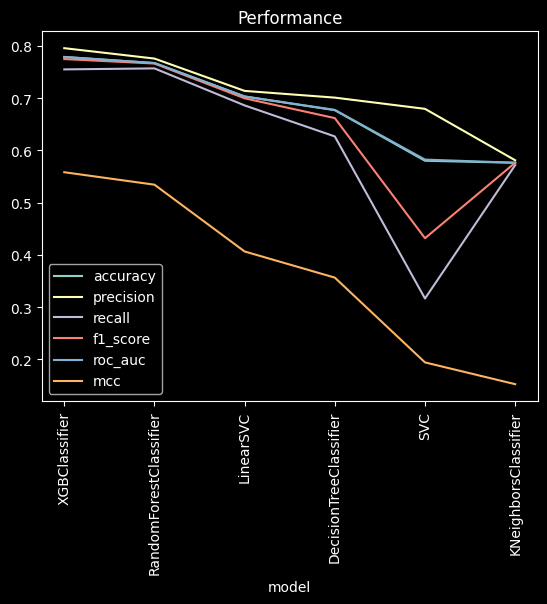

In [18]:
plot_df = results_df[
    [
        "accuracy",
        "precision",
        "recall",
        "f1_score",
        "roc_auc",
        "mcc",
    ]
]

plot_df.plot(kind="line", y=list(plot_df.columns))
plt.xticks(range(len(plot_df)), rotation=90)
plt.title(f"Performance")
with pd.option_context(
    "display.max_rows",
    None,
    "display.max_columns",
    None,
    "display.precision",
    3,
    "display.width",
    1000,
):
    print(results_df)